In [1]:
import torch
import torchvision
import numpy as np
from torchvision.datasets import FashionMNIST
import torchvision.transforms as transforms
from torch import nn
import torch.optim as optim
from matplotlib import pyplot as plt

In [2]:
class Model(nn.Module):
    def __init__(self, internal_activation, final_activation):
        super().__init__()
        self.internal_activation = internal_activation
        self.final_activation = final_activation
        self._freeze(self.internal_activation)
        self._freeze(self.final_activation)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(28*28, 512)
        self.fc2 = nn.Linear(512, 128)
        self.fc3 = nn.Linear(128, 10)

    def forward(self, x):
        y = self.flatten(x)
        y = self.internal_activation(self.fc1(y))
        y = self.internal_activation(self.fc2(y))
        y = self.final_activation(self.fc3(y))
        return y
    
    @classmethod
    def _freeze(cls, x):
        for param in x.parameters():
            param.requires_grad = False

In [3]:
def train(net):
    torch.manual_seed(4783291)
    np.random.seed(8574906)
    criterion = nn.NLLLoss()
    optimizer = optim.Adam(net.parameters(), lr=0.001)
    transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5), (0.5))])
    trainset = FashionMNIST("./data", train=True, download=True, transform=transform)
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=16,
                                              shuffle=True, num_workers=2)
    valset = FashionMNIST("./data", train=True, download=True, transform=transform)
    valloader = torch.utils.data.DataLoader(valset, batch_size=16,
                                            shuffle=True, num_workers=2)
    
    for epoch in range(2):
        running_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs)
            loss = criterion(torch.log(outputs), labels)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
            if i % 2000 == 1999:    # print every 2000 mini-batches
                print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
                running_loss = 0.0

    
    running_correct = 0.0
    running_total = 0.0
    for i, data in enumerate(valloader, 0):
        inputs, labels = data
        outputs = net(inputs)
        running_total += len(labels)
        running_correct += sum(labels.numpy() == np.argmax(outputs.detach().numpy(), axis=1))
    print(f'Finished Training, Val Acc: {running_correct/running_total}')
    return net

In [7]:
def visualize_1d(activation, min_x=-1, max_x=1, samples=21):
    x = np.linspace(min_x, max_x, samples)
    y = activation(torch.from_numpy(x)).numpy()
    plt.plot(x, y)
    plt.show()

In [67]:
def visualize_2d(activation, min_x=-1, max_x=1, min_y=-1, max_y=1, samples=21):
    x = np.linspace(min_x, max_x, samples)
    y = np.linspace(min_y, max_y, samples)
    xx, yy = np.meshgrid(x, y)
    xy = np.stack((xx, yy), axis=-1).reshape((-1, 2))
    z = activation(torch.from_numpy(xy)).numpy().reshape((samples, samples, 2))
    plt.pcolormesh(xx, yy, z[:, :, 0])
    plt.title("x_out")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.colorbar()
    plt.show()
    plt.pcolormesh(xx, yy, z[:, :, 1])
    plt.title("y_out")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.colorbar()
    plt.show()

In [ ]:
model = Model(nn.ReLU(), nn.Softmax(dim=1))
model = train(model)

In [ ]:
class ActivationLayer(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        return torch.sin(x)

model = Model(ActivationLayer(), nn.Softmax(dim=1))
model = train(model)

[1,  2000] loss: 0.598


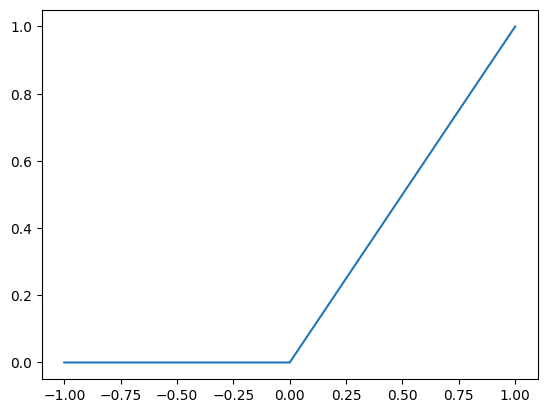

In [8]:
visualize_1d(nn.ReLU())

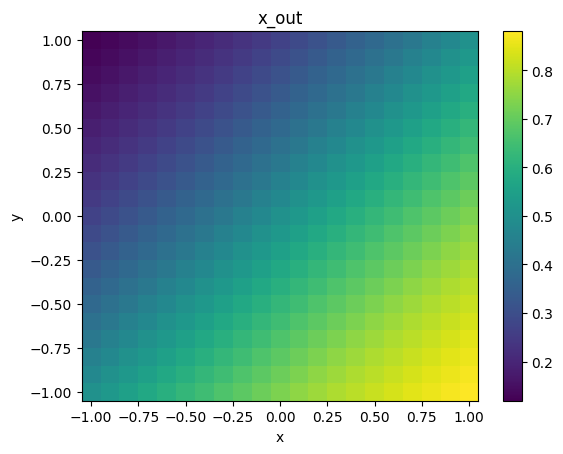

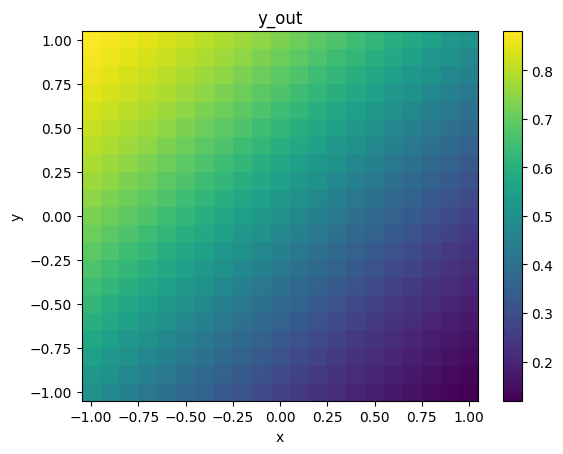

In [68]:
visualize_2d(nn.Softmax(dim=1))